# Setup Env
Training using tfrecord

In [35]:
import os
from functools import partial
import tensorflow as tf
import numpy as np
import gdown
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
TARGET_SIZE = 224

CUSTOM_MODEL_NAME = 'custom-mobnet-pretrained-fromtfrecord'
LABELS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

WORKING_PATHS = {
    'BASE': os.path.join('workspace'),
    'DATASET': os.path.join('workspace', 'dataset'),
    'TFRECORD': os.path.join('workspace', 'dataset', 'tfrecord'),
    'OUTPUT': os.path.join('workspace', 'output'), 
    'EXPORT': os.path.join('workspace', 'output', CUSTOM_MODEL_NAME, 'export'), 
    'TFLITE':os.path.join('workspace', 'output', CUSTOM_MODEL_NAME, 'tfliteexport')
}

In [36]:
# Create working dirs
for path in WORKING_PATHS.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# Downloading tfrecord dataset

In [3]:
# Download dataset
ARCHIVED_NAME = 'hand-sign-bisindo-aToz-cropped-v0.2'
ARCHIVED_FORMAT = '{}.zip'.format(ARCHIVED_NAME)
ARCHIVED_ID = '11rd7hifY1n63BCaUPa4JChQzRTPA1PPH'
GLINK = 'https://drive.google.com/uc?id={}'.format(ARCHIVED_ID)

FILE_PATHS = {
    'TRAIN': os.path.join(WORKING_PATHS['TFRECORD'], ARCHIVED_NAME, 'train.record'),
    'TEST': os.path.join(WORKING_PATHS['TFRECORD'], ARCHIVED_NAME, 'test.record')
}

if not os.path.exists(os.path.join(WORKING_PATHS['TFRECORD'], ARCHIVED_FORMAT)):
    if os.name == 'posix':
        !gdown {GLINK}
        !mv {ARCHIVED_FORMAT} {WORKING_PATHS['TFRECORD']}
        !cd {WORKING_PATHS['TFRECORD']} && unzip -a {ARCHIVED_FORMAT}
    if os.name == 'nt':
        gdown.download(GLINK, ARCHIVED_FORMAT, quiet = False)
        !move {ARCHIVED_FORMAT} {WORKING_PATHS['TFRECORD']}
        !cd {WORKING_PATHS['TFRECORD']} && tar -zxvf {ARCHIVED_FORMAT}

# Create Utils Function to decode tfrecord

In [4]:
def decode_image(image, imageSize):
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*imageSize, 3])
    image = tf.image.resize(image, [224, 224])
    return image

In [5]:
def decode_fn(record_bytes):
    record = tf.io.parse_single_example(
        # Data
        record_bytes,
        # Schema
        {
            'image/height': tf.io.FixedLenFeature([], dtype = tf.int64),
            'image/width': tf.io.FixedLenFeature([], dtype = tf.int64),
            'image/filename': tf.io.FixedLenFeature([], dtype = tf.string),
            'image/source_id': tf.io.FixedLenFeature([], dtype = tf.string),
            'image/encoded': tf.io.FixedLenFeature([], dtype = tf.string),
            'image/format': tf.io.FixedLenFeature([], dtype = tf.string),
            'image/object/bbox/xmin': tf.io.FixedLenFeature([], dtype = tf.float32),
            'image/object/bbox/xmax': tf.io.FixedLenFeature([], dtype = tf.float32),
            'image/object/bbox/ymin': tf.io.FixedLenFeature([], dtype = tf.float32),
            'image/object/bbox/ymax': tf.io.FixedLenFeature([], dtype = tf.float32),
            'image/object/class/text': tf.io.FixedLenFeature([], dtype = tf.string),
            'image/object/class/label': tf.io.FixedLenFeature([], dtype = tf.int64),
        }
    )

    image = tf.cast(record['image/encoded'], tf.string)
    label = tf.cast(record['image/object/class/label'], tf.int64)
    height = tf.cast(record['image/height'], tf.int64)
    width = tf.cast(record['image/width'], tf.int64)
    label = tf.one_hot(label - 1, 26)

    image = decode_image(image, (width, height))
    return (image, label)

In [6]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False 
    dataset = tf.data.TFRecordDataset(filenames) 
    dataset = dataset.with_options(ignore_order) 
    dataset = dataset.map(decode_fn, num_parallel_calls = AUTOTUNE)
    return dataset

In [7]:
def get_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size = AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

In [9]:
def prepare(dataset):
    dataset = dataset.map(lambda x, y: (data_augmentation(x, training = True), y))
    return dataset

# Load and Examine dataset

In [10]:
train_dataset = prepare(get_dataset(FILE_PATHS['TRAIN']))
test_dataset = get_dataset(FILE_PATHS['TEST'])

In [11]:
print(train_dataset.take(1))

<TakeDataset shapes: ((None, 224, 224, 3), (None, 26)), types: (tf.float32, tf.float32)>


In [12]:
image_batch, label_batch = next(iter(train_dataset))

In [13]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        idx = int(label_batch[n].argmax(axis = -1))
        plt.title(LABELS[idx])
        plt.axis("off")

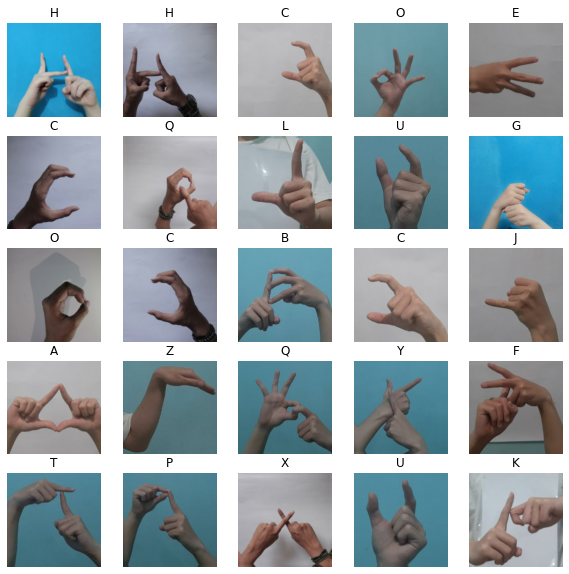

In [14]:
show_batch(image_batch.numpy(), label_batch.numpy())

# Prepare training

In [15]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps = 20, decay_rate = 0.98, staircase = True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience = 10, restore_best_weights = True
)

In [16]:
from tensorflow.keras.applications import MobileNetV2

pre_trained_model = MobileNetV2(
    weights = 'imagenet', 
    input_shape = (224, 224, 3), 
    include_top = False, 
)

for layer in pre_trained_model.layers:
    layer.trainable = False    

In [17]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
# More info about Adam optimzer: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation = 'relu')(x)
# Add a dropout rate of 0.1
x = layers.Dropout(0.1)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(len(LABELS), activation = 'softmax')(x)  

# Re-Create model
model = Model(inputs = pre_trained_model.input, outputs = x)

# Compile Model
model.compile(
    optimizer = Adam(learning_rate = lr_schedule), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

# Start Training

In [18]:
# Start Training!
history = model.fit(
    train_dataset, 
    validation_data = test_dataset, 
    epochs = 40, 
    verbose = 1,
    # callbacks = [early_stopping_cb],
)

Epoch 1/40
55/55 [==============================] - 45s 715ms/step - loss: 85.6789 - accuracy: 0.4675 - val_loss: 1.4426 - val_accuracy: 0.6231
Epoch 2/40
55/55 [==============================] - 40s 693ms/step - loss: 1.2026 - accuracy: 0.7023 - val_loss: 0.8965 - val_accuracy: 0.7839
Epoch 3/40
55/55 [==============================] - 40s 684ms/step - loss: 0.7230 - accuracy: 0.8175 - val_loss: 0.6013 - val_accuracy: 0.8719
Epoch 4/40
55/55 [==============================] - 40s 698ms/step - loss: 0.5265 - accuracy: 0.8773 - val_loss: 0.5051 - val_accuracy: 0.9020
Epoch 5/40
55/55 [==============================] - 40s 703ms/step - loss: 0.3936 - accuracy: 0.9078 - val_loss: 0.6356 - val_accuracy: 0.9070
Epoch 6/40
55/55 [==============================] - 40s 703ms/step - loss: 0.3387 - accuracy: 0.9164 - val_loss: 0.3345 - val_accuracy: 0.9296
Epoch 7/40
55/55 [==============================] - 40s 707ms/step - loss: 0.2994 - accuracy: 0.9351 - val_loss: 0.4175 - val_accuracy: 0.929

# Testing and Evaulate model

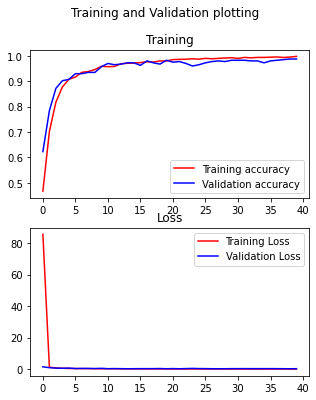

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, axs = plt.subplots(2, 1, figsize = (5, 6))
fig.suptitle('Training and Validation plotting')
axs[0].plot(epochs, acc, 'r', label = 'Training accuracy')
axs[0].plot(epochs, val_acc, 'b', label = 'Validation accuracy')
axs[0].set_title('Training')
axs[0].legend()
axs[1].plot(epochs, loss, 'r', label = 'Training Loss')
axs[1].plot(epochs, val_loss, 'b', label = 'Validation Loss')
axs[1].set_title('Loss')
axs[1].legend()
plt.show()

In [20]:
def createResultPlot(prediction_list, prediction_label, actual_label, image):
    # Result Plot
    fig, axs = plt.subplots(1, 2, figsize = (12, 5))
    fig.suptitle('Image predict as: {}'.format(prediction_label))
    axs = axs.ravel()

    # See other color refrences: https://xkcd.com/color/rgb/
    if prediction_label == actual_label:
        #If prediction True
        fig.patch.set_facecolor('xkcd:mint green')
    else:
        #If prediction False
        fig.patch.set_facecolor('xkcd:pale pink')

    # Show selected image
    axs[0].set_title(actual_label)
    axs[0].imshow(image)

    # Prediction Probabilities Plot
    axs[1].set_title('Probabilities')
    axs[1].bar(range(0, len(LABELS)), prediction_list, align = 'center')
    axs[1].set_xticks(range(0, len(LABELS)))
    axs[1].set_xticklabels(LABELS)

    plt.show()

In [21]:
test_image_batch, test_label_batch = next(iter(test_dataset))

In [22]:
def predict(image, actual_label):
    img_array = tf.expand_dims(image, axis = 0)
    # img_array = preprocess_input(img_array)
    prediction = model.predict(img_array) # Predict Image
    prediction = prediction[0]
    pred_list = prediction.reshape(26)
    index = int(prediction.argmax(axis = -1)) # Get max classes index
    actual_index = int(actual_label.numpy().argmax(axis = -1))
    return (pred_list, LABELS[index], LABELS[actual_index], image)

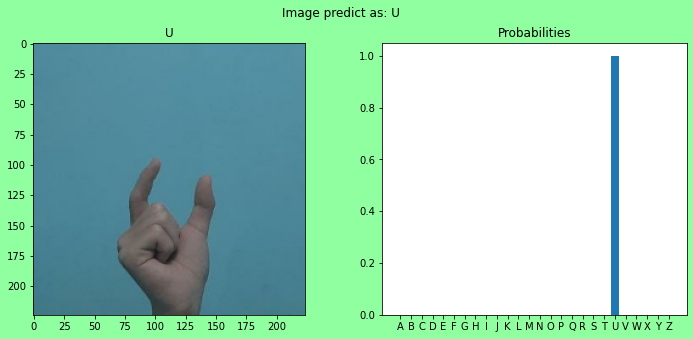

In [25]:
import random

batch_num = random.randint(0, BATCH_SIZE)
pred_list, pred_label, act_label, img = predict(test_image_batch[batch_num], test_label_batch[batch_num])
createResultPlot(pred_list, pred_label, act_label, img)

In [26]:
# Create confussion matrix to all label in test dir
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Variable storing pred
y_true = [] # Actual 
y_pred = [] # Pediction

for batch in iter(test_dataset):
    img_batch, label_batch = batch
    for idx, img in enumerate(img_batch):
        pred_list, pred_label, act_label, img = predict(img, label_batch[idx])
        y_true.append(act_label)
        y_pred.append(pred_label)
        # print('Image with label {} predicted as {}'.format(act_label, pred_label))

mat = confusion_matrix(y_true, y_pred, labels = LABELS)

# Normalize result
mat_norm = mat / mat.astype(np.float).sum(axis = 1)

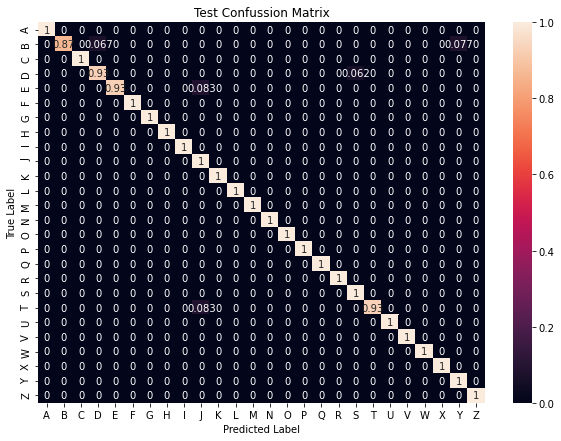

In [27]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(mat_norm, index = LABELS, columns = LABELS)

plt.figure(figsize = (10, 7))
ax = sn.heatmap(df_cm, annot = True)
ax.set_title("Test Confussion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

plt.show()

# Try testing using webcam

In [92]:
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(width, height)

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    crop_img = frame.copy()
    crop_img = crop_img[100:620, 220:740]
    
    # input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)\
    img = tf.image.resize(crop_img, [224, 224])
    img = tf.expand_dims(img, axis = 0)
    img = preprocess_input(img)
    prediction = model.predict(img) # Predict Image
    prediction = prediction[0]
    index = int(prediction.argmax(axis = -1)) # Get max classes index

    cv2.putText(image_np, labels[index], (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), 4)
    cv2.rectangle(image_np, pt1 = (220,100), pt2 = (740,620), color = (0,0,255), thickness = 2)

    cv2.imshow('object detection', image_np)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

960 720


# Save model

In [38]:
# Save model
model.save(os.path.join(os.getcwd(), WORKING_PATHS['EXPORT']))

d:\Capstone\Repo\env_playground\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: d:\Capstone\Repo\workspace\output\custom-mobnet-pretrained-fromtfrecord\export\assets


# Export tflite from saved_model

In [41]:
converter = tf.lite.TFLiteConverter.from_saved_model(WORKING_PATHS['EXPORT']) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open(os.path.join(WORKING_PATHS['TFLITE'], 'model.tflite'), 'wb') as f:
  f.write(tflite_model)

# Export tflite

In [39]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(os.path.join(WORKING_PATHS['TFLITE'], 'model.tflite'), 'wb') as f:
  f.write(tflite_model)

d:\Capstone\Repo\env_playground\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: C:\Users\FROSTY~1\AppData\Local\Temp\tmp2uuzjm8x\assets
